In [145]:
import json
import re
from nltk.tokenize import wordpunct_tokenize
import csv
import numpy as np
from emoji import UNICODE_EMOJI
import dateutil.parser

# DATA_INPUT_FILE = '/data/NER/VectorX/documents_description_objects_100K.json'
DATA_INPUT_FILE = '/data/NER/VectorX/documents_description_objects_100K_random.json'
DATA_ALL_OUTPUT_FILE = '/data/NER/VectorX/dataset.csv'
DATA_TOLOKA_FILE_TEMPLATE = '/data/NER/VectorX/toloka_{}.tsv'

In [119]:
quoter = re.compile(r"(«|»|“|”|``|')")
tokenizer = re.compile(r"[\w']+|[^\w ]")

def tokenize(s):
    return tokenizer.findall(quoter.sub('"', s))

In [120]:
def has_emoji(s):
    for emoji in UNICODE_EMOJI:
        if emoji in s:
            return True
    return False

_bad_beginnings = ['[id', 'Фото', 'Смотрите', 'Скачать', 'Оригинал взят']
_bad_substrings = ['!!', '...']
def check(t: str) -> bool:
    for bb in _bad_beginnings:           
        if t.startswith(bb):
            return False
    for bs in _bad_substrings:
        if bs in t:
            return False
    
    if has_emoji(t):
        return False
    
    return t.count('(') == t.count(')')

In [121]:
%%time
lines = []
data = []
NumberInt = re.compile(r'NumberInt\((\d+)\)')
ISODate = re.compile(r'ISODate\(("[^"]+")\)')
with open(DATA_INPUT_FILE) as f:
    for line in f:
        line = line.rstrip()        
        m1 = NumberInt.findall(line)
        if m1:
            line = NumberInt.sub(m1[0], line)
        m2 = ISODate.findall(line)
        if m2:
            line = ISODate.sub(m2[0], line)
            
        lines.append(line)
        if line == '}':
#             print('\n'.join(lines))
            j_orig = json.loads('\n'.join(lines))
            pub_date = j_orig['rss_pubDate']
        
            assert len(j_orig) == 2
            j = j_orig['rss']            
            
            assert len(j) == 1
            j = j['channel']
            assert len(j) == 1
            j = j['item']
            
            description = j['description']
            guid = j['guid']
            objects = j['objects'].get('object', [])
            
            if description and isinstance(description, str):
                # assert isinstance(description, str), f'"{description}" is not str in object {j_orig}'
                tokenized = tokenize(description)
                description_tokenized = ' '.join(tokenized)
                
                data.append([guid, description, description_tokenized, len(tokenized), pub_date, objects])            
            lines = []

CPU times: user 17.1 s, sys: 123 ms, total: 17.2 s
Wall time: 17.2 s


In [122]:
%%time
with open(DATA_ALL_OUTPUT_FILE, 'w') as fw:
    cw = csv.writer(fw)
    cw.writerow(['guid', 'descriptions', 'description_tokenized', 'token_count', 'pub_date', 'objects'])
    for row in data:
        cw.writerow(row)       

CPU times: user 7.71 s, sys: 600 ms, total: 8.31 s
Wall time: 10.6 s


In [147]:
%%time

target_date = datetime(2017, 8, 1).replace(tzinfo=pytz.UTC).date()
toloka_file = DATA_TOLOKA_FILE_TEMPLATE.format(target_date)

print(f'Writing to file {toloka_file}')

c = 0
with open(toloka_file, 'w') as fw:
    cw = csv.writer(fw, delimiter='\t')
    cw.writerow(['INPUT:guid', 'INPUT:orig', 'INPUT:input'])
    for guid, descriptions, description_tokenized, token_count, pub_date, objects in data:        
        row_date = dateutil.parser.parse(pub_date).date()
        if 40 < token_count < 1750 and row_date == target_date:
            c += 1
            cw.writerow([guid, description, description_tokenized])
print(f'wrote {c} articles')

Writing to file /data/NER/VectorX/toloka_2017-08-01.tsv
wrote 3831 articles
CPU times: user 7.34 s, sys: 15.6 ms, total: 7.36 s
Wall time: 7.36 s


In [66]:
len([d for d in ds if d < datetime(2017, 8, 5).replace(tzinfo=pytz.UTC)])

17024

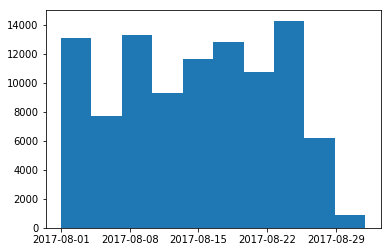

In [15]:
import matplotlib.pyplot as plt
plt.hist(ds)
plt.show()

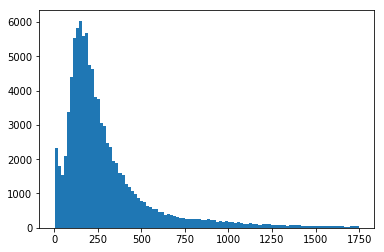

In [126]:
plt.hist(L[L<1750], bins=100)
plt.show()